In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
import shutil
navoneel_brain_mri_images_for_brain_tumor_detection_path = kagglehub.dataset_download('navoneel/brain-mri-images-for-brain-tumor-detection')
save_path = "/content/drive/My Drive/CS441/MRI"
shutil.move(navoneel_brain_mri_images_for_brain_tumor_detection_path, save_path)

'/content/drive/My Drive/CS441/MRI/1'

In [53]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [51]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
import cv2
import os
import matplotlib.pyplot as plt

In [52]:
def load_images(image_folder, target_size):
    images = []
    labels = []
    folder0 = image_folder + "/no"
    folder1 = image_folder + "/yes"
    for _, _, filenames in os.walk(folder0):
        for filename in filenames:
            path = folder0 + '/' + filename
            img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, target_size)
            images.append(img.flatten())
            labels.append(0)
    for _, _, filenames in os.walk(folder1):
        for filename in filenames:
            path = folder1 + '/' + filename
            img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, target_size)
            images.append(img.flatten())
            labels.append(1)
    return np.array(images), np.array(labels)

In [54]:
image_folder = "/content/drive/My Drive/CS441/MRI/brain_tumor_dataset"
size = (224,224)
images, labels = load_images(image_folder, size)

In [55]:
indices = np.arange(len(images))
np.random.shuffle(indices)
images = images[indices]
labels = labels[indices]

In [ ]:
# KNN
train_X = images[:177]
train_y = labels[:177]
val_X = images[177:215]
val_y = labels[177:215]
test_X = images[215:]
test_y = labels[215:]

In [ ]:
def KNN_predict(X, y, X_query, k, weighted):
    neighbor_dist = np.sqrt(np.sum((X_query - X)**2, axis=1))
    indices = np.argsort(neighbor_dist)[:k]
    neighbor_y = y[indices]

    if weighted:
        dist = neighbor_dist[indices]
        weights = 1 / (dist + 1e-10)
        pred = np.sum(neighbor_y * weights) / np.sum(weights)
    else:
        pred = np.mean(neighbor_y)

    label = 1 if pred > 0.5 else 0
    return label

In [ ]:
def evaluate(train_X, test_X, train_y, test_y, k, weighted):
    correct = 0
    for i in range(len(test_X)):
        if KNN_predict(train_X,train_y,test_X[i], k, weighted) == test_y[i]:
            correct += 1
    return correct/len(test_y)

In [ ]:
k_val = [1,3,5,7,9]
accuracy_uw = []
accuracy_w = []
for k in k_val:
    accuracy_uw.append(evaluate(train_X, val_X, train_y, val_y, k, 0))
    accuracy_w.append(evaluate(train_X, val_X, train_y, val_y, k, 1))

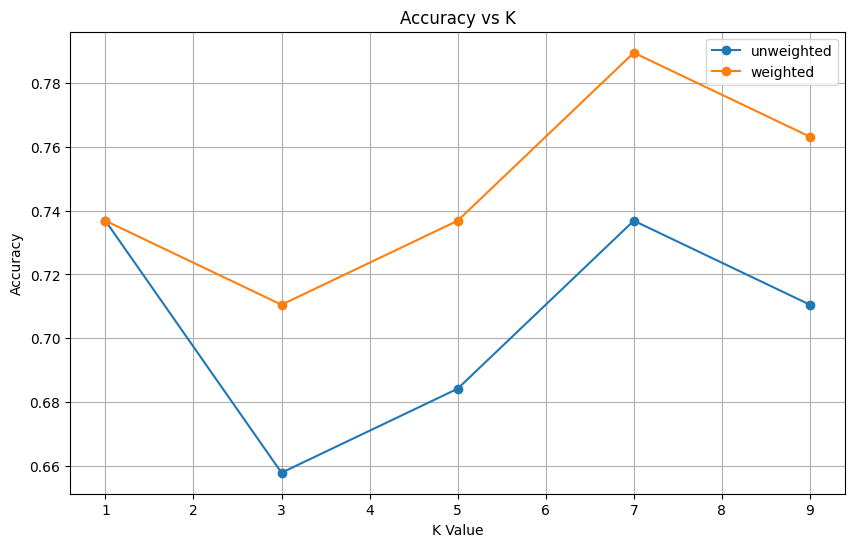

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(k_val, accuracy_uw, label = "unweighted", marker='o')
plt.plot(k_val, accuracy_w, label = "weighted", marker='o')
plt.title('Accuracy vs K')
plt.xlabel('K Value')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
print(evaluate(train_X, test_X, train_y, test_y, 7, 1))

0.7631578947368421


In [ ]:
# PCA + random forest
scaler = StandardScaler()
images = scaler.fit_transform(images)
pca = PCA(n_components=25)
images_pca = pca.fit_transform(images)
train_X = images_pca[:177]
train_y = labels[:177]
val_X = images_pca[177:215]
val_y = labels[177:215]
test_X = images_pca[215:]
test_y = labels[215:]

feature_num = [2, 5, 10, 18, 25]
tree_num = [100,300,500]
accuracy_array = np.zeros((3,5))
for i in range(len(tree_num)):
    for j in range(len(feature_num)):
        rf_model = RandomForestClassifier(n_estimators=tree_num[i], random_state=42, max_features=feature_num[j])
        rf_model.fit(train_X, train_y)
        pred = rf_model.predict(val_X)
        accuracy = accuracy_score(val_y, pred)
        accuracy_array[i][j] = accuracy

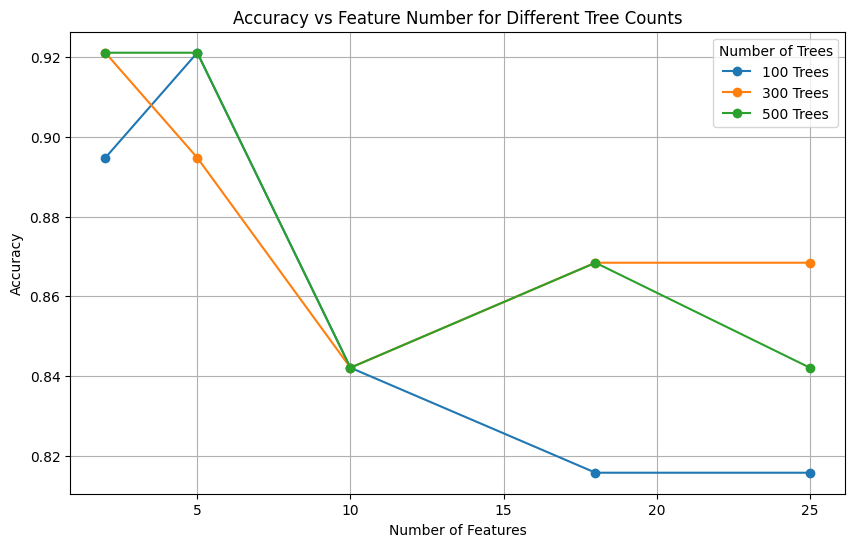

In [ ]:
# Plotting
plt.figure(figsize=(10, 6))
for i, tree in enumerate(tree_num):
    plt.plot(feature_num, accuracy_array[i], label=f'{tree} Trees', marker='o')

plt.title('Accuracy vs Feature Number for Different Tree Counts')
plt.xlabel('Number of Features')
plt.ylabel('Accuracy')
plt.legend(title='Number of Trees')
plt.grid(True)
plt.show()

In [ ]:
rf_model = RandomForestClassifier(n_estimators=500, random_state=42, max_features=5)
rf_model.fit(train_X, train_y)
pred = rf_model.predict(test_X)
accuracy = accuracy_score(test_y, pred)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

Test Accuracy: 92.11%


In [ ]:
# Deep Learing (CNN)
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
from torch.utils.data import random_split
from sklearn.metrics import accuracy_score
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import os

In [70]:
save_dir = "/content/drive/My Drive/CS441/MRI"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [71]:
path = "/content/drive/My Drive/CS441/MRI/brain_tumor_dataset"

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = datasets.ImageFolder(path, transform=train_transform)
test_dataset = datasets.ImageFolder(path, transform=test_transform)

dataset_size = len(train_dataset)
train_end = int(0.7 * dataset_size)
val_end = int(0.85 * dataset_size)
test_end = dataset_size

train_indices = list(range(0, train_end))
val_indices = list(range(train_end, val_end))
test_indices = list(range(val_end, test_end))

train_dataset = Subset(train_dataset, train_indices)
val_dataset = Subset(test_dataset, val_indices)
test_dataset = Subset(test_dataset, test_indices)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

In [ ]:
def initializeModel(num_target_classes = 2):
  # loads a pre-trained ResNet-34 model
  model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet34', pretrained=True)

  in_features = model.fc.in_features
  model.fc = nn.Linear(in_features, num_target_classes)

  for name, param in model.named_parameters():
    param.requires_grad = True
  # for name, param in model.named_parameters():
  #   if "layer4" in name or "fc" in name:
  #       param.requires_grad = True
  #   else:
  #       param.requires_grad = False
  model = model.to(device)

  return model

In [ ]:
def train(train_loader, model, criterion, optimizer):
    model.train()
    loss_ = 0.0
    losses = []

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        pred = model(images)
        loss = criterion(pred, labels)
        loss.backward()
        optimizer.step()
        losses.append(loss)
    return torch.stack(losses).mean().item()

def test(test_loader, model, criterion):
    model.eval()
    losses = []
    correct = 0
    total = 0
    for images, labels in test_loader:
      images, labels = images.to(device), labels.to(device)
      with torch.no_grad():
       output = model(images)
      preds = torch.argmax(output, dim=-1)
      loss = criterion(output, labels)
      losses.append(loss.item())
      correct += (preds == labels).sum().item()
      total += len(labels)

    mean_accuracy = correct / total
    test_loss = np.mean(losses)
    print('Mean Accuracy: {0:.4f}'.format(mean_accuracy))
    print('Avg loss: {}'.format(test_loss))

    return mean_accuracy, test_loss

In [ ]:
# Plot loss or accuracy
def plot_losses(train, val, test_frequency, num_epochs):
    plt.plot(train, label="train")
    indices = [i for i in range(num_epochs) if ((i+1)%test_frequency == 0 or i ==0 or i == 1)]
    plt.plot(indices, val, label="val")
    plt.title("Loss Plot")
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    plt.legend()
    plt.show()

def plot_accuracy(train, val, test_frequency, num_epochs):
    indices = [i for i in range(num_epochs) if ((i+1)%test_frequency == 0 or i ==0 or i == 1)]
    plt.plot(indices, train, label="train")
    plt.plot(indices, val, label="val")
    plt.title("Accuracy Plot")
    plt.ylabel("Accuracy")
    plt.xlabel("Epoch")
    plt.legend()
    plt.show()

def save_checkpoint(save_dir, model, save_name):
    save_path = os.path.join(save_dir, save_name)
    torch.save(model.state_dict(), save_path)

def load_model(model, save_dir, save_name):
    save_path = os.path.join(save_dir, save_name)
    model.load_state_dict(torch.load(save_path))
    return model

In [ ]:
epochs = 20
def train_epoch(train_loader, learn_rate, max_accuracy):
  model = initializeModel()
  model = model.to(device)
  optimizer = torch.optim.SGD(model.parameters(), lr=learn_rate, weight_decay = 0.005, momentum = 0.9)
  lr_scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda epoch: min(1, epoch / 5))
  criterion = torch.nn.CrossEntropyLoss()
  train_losses = []
  train_accuracy_list = []
  test_losses = []
  test_accuracy_list = []
  for epoch in range(epochs):
      # Train the network for one epoch
      train_loss = train(train_loader, model, criterion, optimizer)

      # TO DO: uncomment the line below. It should be called each epoch to apply the lr_scheduler
      lr_scheduler.step()

      train_losses.append(train_loss)
      print(f'Loss for Training on epoch {str(epoch)} is {str(train_loss)} \n')

      # Get the train accuracy and test loss/accuracy
      print('Evaluating Network')

      train_accuracy, _ = test(train_loader, model, criterion) # Get training accuracy
      train_accuracy_list.append(train_accuracy)

      print(f'Training accuracy on epoch {str(epoch)} is {str(train_accuracy)} \n')

      test_accuracy, test_loss = test(test_loader, model, criterion) # Get testing accuracy and error
      test_losses.append(test_loss)
      test_accuracy_list.append(test_accuracy)
      print(f'Test (val) accuracy on epoch {str(epoch)} is {str(test_accuracy)} \n')

      # Checkpoints are used to save the model with best validation accuracy
      if test_accuracy >= max(test_accuracy_list):
        print("Saving Model")
        name = 'best_model' + str(learn_rate)+ '.pth'
        save_checkpoint(save_dir, model, save_name = name) # Save model with best performance
  plot_losses(train_losses, test_losses, 1, epochs)
  plot_accuracy(train_accuracy_list, test_accuracy_list, 1, epochs)
  return max(test_accuracy_list)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Loss for Training on epoch 0 is 0.7901452779769897 

Evaluating Network
Mean Accuracy: 0.5198
Avg loss: 0.7514812548955282
Training accuracy on epoch 0 is 0.519774011299435 

Mean Accuracy: 0.0263
Avg loss: 1.113172471523285
Test (val) accuracy on epoch 0 is 0.02631578947368421 

Saving Model
Loss for Training on epoch 1 is 0.5916913747787476 

Evaluating Network
Mean Accuracy: 0.7740
Avg loss: 0.4538894643386205
Training accuracy on epoch 1 is 0.7740112994350282 

Mean Accuracy: 0.1842
Avg loss: 1.3700039982795715
Test (val) accuracy on epoch 1 is 0.18421052631578946 

Saving Model
Loss for Training on epoch 2 is 0.3469502925872803 

Evaluating Network
Mean Accuracy: 0.8588
Avg loss: 0.31740717093149823
Training accuracy on epoch 2 is 0.8587570621468926 

Mean Accuracy: 0.3421
Avg loss: 1.2298727631568909
Test (val) accuracy on epoch 2 is 0.34210526315789475 

Saving Model
Loss for Training on epoch 3 is 0.11749690771102905 

Evaluating Network
Mean Accuracy: 0.8870
Avg loss: 0.304840

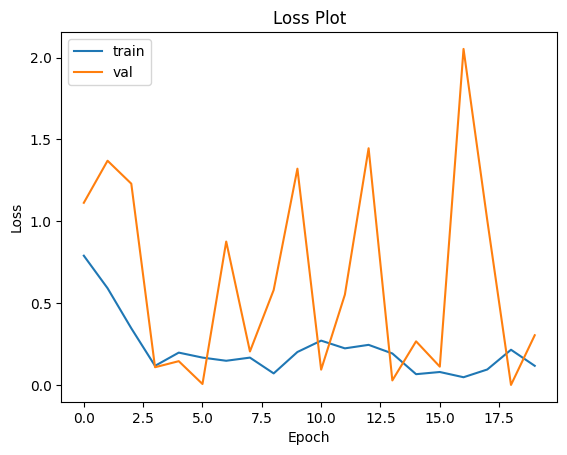

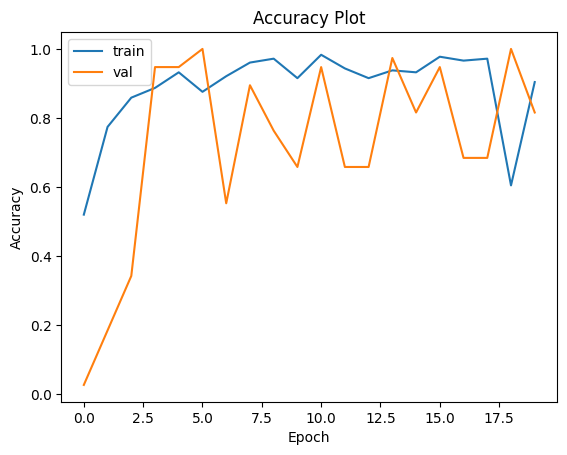

---------------------------------------
0
---------------------------------------


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Loss for Training on epoch 0 is 0.775993287563324 

Evaluating Network
Mean Accuracy: 0.3616
Avg loss: 0.8636252582073212
Training accuracy on epoch 0 is 0.3615819209039548 

Mean Accuracy: 0.3684
Avg loss: 0.7639484405517578
Test (val) accuracy on epoch 0 is 0.3684210526315789 

Saving Model
Loss for Training on epoch 1 is 0.6447864770889282 

Evaluating Network
Mean Accuracy: 0.5876
Avg loss: 0.6363847553730011
Training accuracy on epoch 1 is 0.5875706214689266 

Mean Accuracy: 0.0263
Avg loss: 1.2890053987503052
Test (val) accuracy on epoch 1 is 0.02631578947368421 

Loss for Training on epoch 2 is 0.3642730414867401 

Evaluating Network
Mean Accuracy: 0.8757
Avg loss: 0.34865378091732663
Training accuracy on epoch 2 is 0.8757062146892656 

Mean Accuracy: 0.8421
Avg loss: 0.4590041786432266
Test (val) accuracy on epoch 2 is 0.8421052631578947 

Saving Model
Loss for Training on epoch 3 is 0.33801302313804626 

Evaluating Network
Mean Accuracy: 0.9661
Avg loss: 0.12366403639316559
Tr

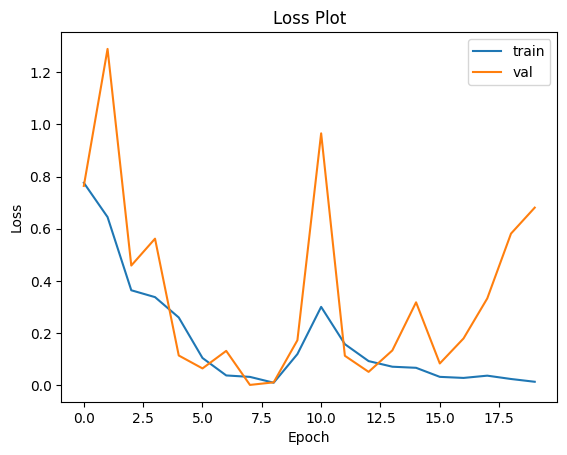

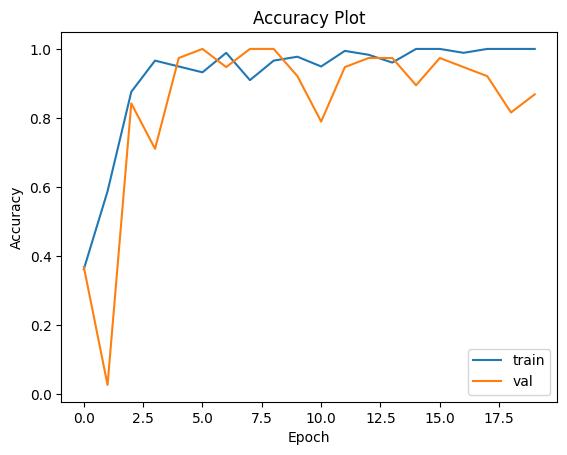

---------------------------------------
1.0
---------------------------------------


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Loss for Training on epoch 0 is 0.7291735410690308 

Evaluating Network
Mean Accuracy: 0.5706
Avg loss: 0.6755001743634542
Training accuracy on epoch 0 is 0.5706214689265536 

Mean Accuracy: 0.0789
Avg loss: 1.1400740146636963
Test (val) accuracy on epoch 0 is 0.07894736842105263 

Saving Model
Loss for Training on epoch 1 is 0.6967819929122925 

Evaluating Network
Mean Accuracy: 0.6328
Avg loss: 0.6562768220901489
Training accuracy on epoch 1 is 0.632768361581921 

Mean Accuracy: 0.4737
Avg loss: 0.719279557466507
Test (val) accuracy on epoch 1 is 0.47368421052631576 

Saving Model
Loss for Training on epoch 2 is 0.5839928388595581 

Evaluating Network
Mean Accuracy: 0.6723
Avg loss: 0.5890142718950907
Training accuracy on epoch 2 is 0.672316384180791 

Mean Accuracy: 0.6842
Avg loss: 0.5886653959751129
Test (val) accuracy on epoch 2 is 0.6842105263157895 

Saving Model
Loss for Training on epoch 3 is 0.47521013021469116 

Evaluating Network
Mean Accuracy: 0.8305
Avg loss: 0.427139982

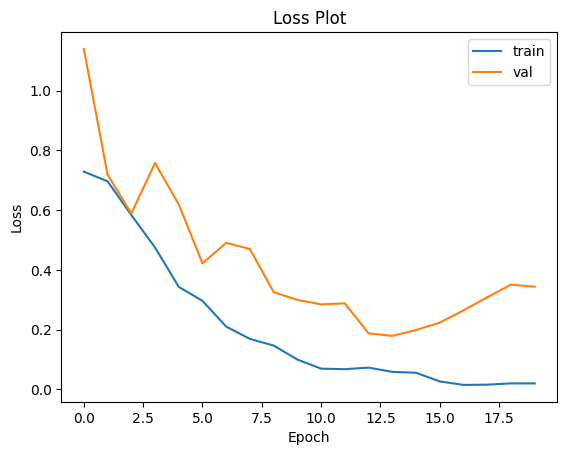

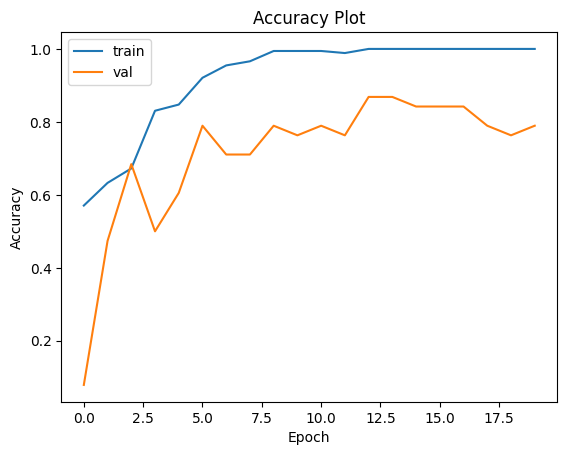

---------------------------------------
1.0
---------------------------------------


In [ ]:
learning_rate = [0.01, 0.005, 0.001]
max_accuracy = 0
for lr in learning_rate:
  new_max = train_epoch(train_loader, lr, max_accuracy)

  print("---------------------------------------")
  print(max_accuracy)
  print("---------------------------------------")
  if new_max > max_accuracy:
    max_accuracy = new_max

In [ ]:
model = initializeModel()

load_model(model, save_dir, "best_model0.005.pth") # Load the trained weights
criterion = torch.nn.CrossEntropyLoss()
test_accuracy, test_loss= test(test_loader, model, criterion)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
<ipython-input-33-502905cec1a1>:28: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(to

Mean Accuracy: 1.0000
Avg loss: 0.011479995911940932
